# Second exercise (Chapter 6 & 8)

In this exercise we consider Chapters 6 & 8 of the book "Deep Learning". The exercise focuses on implementing a small feedforward neural network and training it on the MNIST dataset.

We provide code for structure and utility, you have to **fill in the TODO-gaps**.
It might initially look like a lot of unnecessary code, but it keeps the network extensible. In the following exercises you can reuse what you've done here. Most common neural network libraries (*pytorch*, *tensorflow/keras*, …) are similarly structured, hence they will be easy to use once you've finished this notebook. As we will be using *pytorch* towards the end of the lecture, our API resembles the API of the pytorch framework.


We will implement two different cost functions and play a bit with the value of the different hyperparameters to see how performances change as a function of those. In particular, we will focus on

* Sigmoid Neurons
* Stochastic Gradient Descent
* Quadratic Cost Function
* Cross Entropy Cost Function
* Learning Rate
* Generalization

Note that we'll implement all of these operations to operate on mini-batches of data.

In [45]:
# Some imports used in the code below

from typing import Iterable, List, Optional, Tuple  # type annotations
import pickle  # data loading
import gzip  # data loading

import numpy as np  # linear algebra
import matplotlib.pyplot as plt  # plotting
import scipy.optimize  # gradient check

The cell below contains the two main classes to structure your network. 

**Parameter** is used to represent trainable variables in the network, e.g., a layer's weights $w$. The weights themself are a *numpy array* as the parameter's `data` attribute. The associated parameter gradient (e.g. $\frac{\partial L}{\partial w}$) can be stored in the `grad` attribute.



**Module** is the base class for all parts of the network (activations, layers, …) and even the network itself. They all have to implement the `forward` and `backward` methods. For backpropagation activation will flow *forward* and gradient will flow *backward* through the *network graph and it's modules*. 

Additional module provides utility to check the correctness of implementation by approximating *backward* with [finite difference approximations](https://en.wikipedia.org/wiki/Finite_difference#Relation_with_derivatives)  of *forward*.

*Note:* All modules operate on batches of samples. E.g. the input shape of `Linear.forward` is `(batch_size, feature_shape, 1)` (we will use the last dimension in future exercises).

In [46]:
class Parameter:
    """A trainable parameter.

    This class not only stores the value of the parameter (self.data) but also tensors/
    properties associated with it, such as the gradient (self.grad) of the current backward
    pass.
    """

    def __init__(self, data: np.ndarray, name=None, grad: Optional[np.ndarray] = None):
        self.data = data  # type: np.ndarray
        self.grad = grad  # type: Optional[np.ndarray]
        self.name = name  # type: Optional[str]
        self.state_dict = dict()  # dict to store additional, optional information
        
        
class Module:
    """The base class all network modules must inherit from."""

    def __init__(self):
        # Cache of the input of the forward pass.
        # We need it during the backward pass in most layers,
        #  e.g., to compute the gradient w.r.t to the weights.
        self.input_cache = None

    def __call__(self, *args) -> np.ndarray:
        """Alias for forward, convenience function."""
        return self.forward(*args)

    def forward(self, *args) -> np.ndarray:
        """Compute the forward pass through the module.

        Args:
           args: The inputs, e.g., the output of the previous layer.
        """
        raise NotImplementedError

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Compute the backward pass through the module.

        This method computes the gradients with respect to the trainable
        parameters and with respect to the first input.
        If the module has trainable parameters, this method needs to update
        the respective parameter.grad property.

        Args:
            grad: The gradient of the following layer.

        Returns:
            The gradient with respect to the first input argument. In general
            it might be useful to return the gradients w.r.t. to all inputs, we
            omit this here to keep things simple.
        """
        raise NotImplementedError

    def parameters(self) -> List[Parameter]:
        """Return the module parameters."""
        return []  # default to empty list

    def check_gradients(self, input_args: Tuple[np.ndarray]):
        """Verify the implementation of the gradients.

        This includes the gradient with respect to the input as well as the
        gradients w.r.t. the parameters if the module contains any.

        As the scipy grad check only works on scalar functions, we compute
        the sum over the output to obtain a scalar.
        """
        assert isinstance(input_args, tuple), (
            "input_args must be a tuple but is {}".format(type(input_args)))
        TOLERANCE = 1e-6
        self.check_gradients_wrt_input(input_args, TOLERANCE)
        self.check_gradients_wrt_params(input_args, TOLERANCE)

    def _zero_grad(self):
        """(Re-) intialize the param's grads to 0. Helper for grad checking."""
        for p in self.parameters():
            p.grad = np.zeros_like(p.data)

    def check_gradients_wrt_input(self, input_args: Tuple[np.ndarray],
                                  tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. input."""

        def output_given_input(x: np.ndarray):
            """Wrap self.forward for scipy.optimize.check_grad."""
            # we only compute the gradient w.r.t. to the first input arg.
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            return np.sum(self.forward(*args))

        def grad_given_input(x: np.ndarray):
            """Wrap self.backward for scipy.optimize.check_grad."""
            self._zero_grad()
            # run self.forward to store the new input
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            out = self.forward(*args)
            # compute the gradient w.r.t. to the input
            return np.ravel(self.backward(np.ones_like(out)))

        error = scipy.optimize.check_grad(
            output_given_input, grad_given_input, np.ravel(input_args[0]))
        num_outputs = np.prod(self.forward(*input_args).shape)
        if np.squeeze(error) / num_outputs > tolerance:
            raise RuntimeError("Check of gradient w.r.t. to input for {} failed."
                               "Error {:.4E} > {:.4E}."
                               .format(self, np.squeeze(error), tolerance))

    def check_gradients_wrt_params(self, input_args: Tuple[np.ndarray],
                                   tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. params."""
        print("len(self.parameters()) / ", str(len(self.parameters())))
        for param in self.parameters():
            def output_given_params(new_param: np.ndarray):
                """Wrap self.forward, change the parameters to new_param."""
                param.data = new_param.reshape(param.data.shape)
                ogp = np.sum(self.forward(*input_args))
                return ogp

            def grad_given_params(new_param: np.ndarray):
                self._zero_grad()
#                 for p in self.parameters():
#                     print("param / ", p)
                param.data = new_param.reshape(param.data.shape)
#                 print(param.name, " param.data.shape /", param.data.shape)
                out = self.forward(*input_args)
#                 print("out.shape /", str(out.shape))
                # compute the gradient w.r.t. to param
                self.backward(np.ones_like(out))
                ggp = np.ravel(param.grad)
#                 print("ggp.shape /", str(ggp.shape))
                return ggp
            
            # flatten the param as scipy can only handle 1D params
            param_init = np.ravel(np.copy(param.data))
            print("param_init.shape / " + str(param_init.shape))
            error = scipy.optimize.check_grad(output_given_params,
                                              grad_given_params,
                                              param_init)
            num_outputs = np.prod(self.forward(*input_args).shape)
            if np.squeeze(error) / num_outputs > tolerance:
                raise RuntimeError("Check of gradient w.r.t. to param '{}' for"
                                   "{} failed. Error {:.4E} > {:.4E}."
                                   .format(param.name, self, error, tolerance))

# Nonlinearities

## Sigmoid 

Implement your first network module: The sigmoid activation function.

Verify your sigmoid function by plotting.

In [47]:
class Sigmoid(Module):
    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        # START TODO ################
        return 1.0/(1.0 + np.exp(-z))
        # END TODO###################

    def forward(self, z: np.ndarray) -> np.ndarray:
        assert len(z.shape) == 3, ("z.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(z.shape))
        h = self._sigmoid(z)
        # here it's useful to store the activation 
        #  instead of the input
        self.input_cache = h
        return h

    def backward(self, grad: np.ndarray) -> np.ndarray:
        h = self.input_cache
#         print("SIG backward /", grad.shape)
        # START TODO ################
        sigd = h * (1.0 - h)
        return grad * sigd
        # END TODO###################

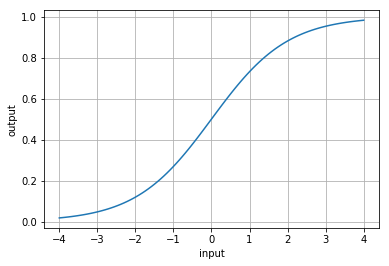

In [48]:
x = np.linspace(-4, +4, 100)
sigmoid = Sigmoid()

y = np.ravel(sigmoid(x.reshape(-1, 1, 1)))
# equal to call of sigmoid.forward(x)
    
plt.plot(x,y)
plt.xlabel('input')
plt.ylabel('output')
plt.grid(True)
plt.show()

## Relu

Implement Relu and plot for verification

In [49]:
class Relu(Module):
    def _relu(self, z: np.ndarray) -> np.ndarray:
        # START TODO ################
        # print("#METOO")
        return np.maximum(0.0, z)
        # END TODO###################
        
    def forward(self, z: np.ndarray) -> np.ndarray:
        self.input_cache = z
        # START TODO ################
        # print("CALLED")
        return self._relu(z)
        # END TODO###################

    def backward(self, grad: np.ndarray) -> np.ndarray:
        z = self.input_cache
#         print("ReLU backward /", grad.shape)
        # START TODO ################
        grad_r = np.ones_like(z)
        grad_r[z < 0.0] = 0.0
        return grad_r * grad
        # END TODO###################

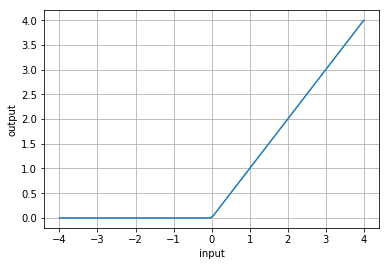

In [50]:
# Plot Relu

# START TODO ################
x = np.linspace(-4, +4, 100)
relu = Relu()

y = np.ravel(relu(x.reshape(-1, 1, 1)))
# equal to call of sigmoid.forward(x)
    
plt.plot(x,y)
plt.xlabel('input')
plt.ylabel('output')
plt.grid(True)
plt.show()
# END TODO###################

## Softmax

Implement the numerical stable softmax. We will not need the backward pass. 

In [51]:
class Softmax(Module):
    def _softmax(self, z):
        # don't reduce (sum) over batch axis
        reduction_axes = tuple(range(1, len(z.shape))) 
        
        # START TODO ################
        z_max = np.max(z, axis=reduction_axes, keepdims=True)
        # Shift input for numerical stability.
        z_safe = z - z_max
        e_z = np.exp(z_safe)
        h = e_z / np.sum(e_z, axis=reduction_axes, keepdims=True)
        # END TODO###################
        return h
        raise NotImplementedError
    
    def forward(self, z: np.ndarray) -> np.ndarray:
        h = self._softmax(z)
        return h

    def backward(self, grad) -> np.ndarray:
        error_msg = ("Softmax doesn't need to implement a gradient here, as it's"
                     "only needed in CrossEntropyLoss, where we can simplify"
                     "the gradient for the combined expression.")
        raise NotImplementedError(error_msg)


In [52]:
# Check your softmax
softmax = Softmax()
x = np.array([1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0]).reshape(1, -1, 1)

# Testcase from https://en.wikipedia.org/wiki/Softmax_function#Example
np.testing.assert_allclose(
    np.ravel(softmax(x)), 
    [0.02364054, 0.06426166, 0.1746813, 0.474833, 0.02364054, 0.06426166, 0.1746813],
    rtol=1e-5, err_msg="Softmax is not correct implemented")


# Linear Layer

Implement a linear (in other frameworks also called dense or fully connected) network layer. 
Here you also have to use the Parameter class.

In [53]:
class Linear(Module):

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        
        w_data = 0.01 * np.random.randn(out_features, in_features)
        self.W = Parameter(w_data, "W")
        
        b_data = 0.01 * np.ones((out_features, 1))
        self.b = Parameter(b_data, "b")
        
        print("init / self.W.shape", self.W.data.shape)
        print("init / self.b.shape", self.b.data.shape)

    def forward(self, x: np.ndarray) -> np.ndarray:
        assert len(x.shape) == 3, ("x.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(x.shape))
        self.input_cache = x
        # START TODO ################
        # Remember: Access weight data through self.W.data
        # z = np.dot(self.input_cache, self.W.data) + self.b.data
        z = (self.W.data @ self.input_cache) + self.b.data

#         print("LIN forward:")
#         print("self.W.data.shape : " + str(self.W.data.shape))
#         print("self.input_cache.shape : " + str(self.input_cache.shape))
#         print("self.b.data.shape : " + str(self.b.data.shape))
#         print("z = (self.W.data @ self.input_cache) + self.b.data")
#         print("z.shape : " + str(z.shape))

        return z
        # END TODO ##################

    def backward(self, grad: np.ndarray) -> np.ndarray:
        x = self.input_cache
        # remember that input has a batch dimension when transposing, i.e.,
        # we need to use np.transpose instead of x.T
        x_transpose = np.transpose(x, [0, 2, 1])
        # START TODO ################ 
        # self.W.grad += ...
        # ..
#         print("LIN backward B4")
#         print("dz.shape : " + str(dz.shape))
#         print("dz.T.shape : " + str(dz.T.shape))
#         print("x.shape : " + str(x.shape))
#         print("x_transpose.shape : " + str(x_transpose.shape))
#         print("n.shape : " + str(n))
#         print("self.W.grad.shape : " + str(self.W.grad.shape))
#         print("self.b.grad.shape : " + str(self.b.grad.shape))
#         print("self.W.data.shape :", self.W.data.shape)
#         print("self.W.data.T.shape :", self.W.data.T.shape)
        dz = self.W.data.T @ grad
        self.W.grad += np.sum((grad @ x_transpose), axis=0)
        self.b.grad += np.sum(grad, axis=0)
#         print("LIN backward AFTER")
#         print("dz.shape : " + str(dz.shape))
#         print("self.W.grad.shape : " + str(self.W.grad.shape))
#         print("self.b.grad.shape : " + str(self.b.grad.shape))
        return dz
        # END TODO ##################

    def parameters(self) -> List[Parameter]:
        # START TODO ################ 
        # Return all parameters of Linear
        # return [self.W, self.b]
#         print("params / " + str(len(np.ravel([self.W, self.b]))))
        return [self.W, self.b]
        # END TODO ##################

# Cost Functions



In [54]:
# Define the Cross-Entropy cost functions
class CrossEntropyLoss(Module):
    """Compute the cross entropy."""

    def __init__(self):
        super().__init__()
        self.softmax = Softmax()

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Compute the cross entropy, mean over batch size."""
        a = self.softmax(a)
        self.input_cache = a, y
        # compute the mean over the batch
        return -np.sum(np.log(a[y == 1])) / len(a)

    def backward(self, _=None) -> np.ndarray:
        # we introduce the argument _ here, to have a unified interface with
        # other Module objects. This simplifies code for gradient checking. 
        # We don't need this arg.
        a, y = self.input_cache
        
        # START TODO ################
        # note to self : also check for division by n (shape[0])
        cel_grad = (a - y) / len(y)
        cel_grad = cel_grad[:,:,np.newaxis]
        # Recreate the batch dimension
        # END TODO ##################
        
        assert len(cel_grad.shape) == 3, ("CrossEntropyLoss.backward should return (batch_size, grad_size, 1)"
                                      " but is {}.".format(cel_grad.shape))
        return cel_grad


class MSELoss(Module):
    """Compute the mean squared error loss."""

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        self.input_cache = a, y
        return np.sum(0.5 * np.linalg.norm(a - y, axis=-1)**2) / len(a)

    def backward(self, _=None):
        # we introduce the argument _ here, to have a unified interface with
        # other Module objects. This simplifies code for gradient checking. 
        # We don't need this arg
        a, y = self.input_cache
        
        # START TODO ################ 
        # raise NotImplementedError
        # note to self : also check for division by n (shape[0])
        msel_grad = (a - y) / len(y)
        msel_grad = msel_grad[:,:,np.newaxis]
        # Recreate the batch dimension
        # END TODO ##################
        
        assert len(msel_grad.shape) == 3, ("MSELossCrossEntropyLoss.backward should return (batch_size, grad_size, 1)"
                                      " but is {}.".format(msel_grad.shape))
        return msel_grad

# Sequential Network

In [55]:
class Sequential(Module):
    """A sequential container to stack modules.

    Modules will be added to it in the order they are passed to the
    constructor.

    Example network with one hidden layer:
    model = Sequential(
                  Linear(5,10),
                  ReLU(),
                  Linear(10,10),
                )
    """
    def __init__(self, *args: List[Module]):
        super().__init__()
        self.modules = args

    def forward(self, x: np.ndarray) -> np.ndarray:
        # START TODO ################
        for mod in self.modules:
            x = mod.forward(x)
        return x
        raise NotImplementedError
        # Remember: module(x) is equivalent to module.forward(x)
        # END TODO ##################
        # return x

    def backward(self, grad: np.ndarray) -> np.ndarray:
        # START TODO ################
#         print("SEQ backward /", grad.shape)
        n = len(self.modules)
        for i in range(n-1, -1, -1):
            grad = self.modules[i].backward(grad)
        return grad
        # END TODO ##################

    def parameters(self) -> List[Parameter]:
        # iterate over modules and retrieve their parameters, iterate over
        # parameters to flatten the list
        return [param for module in self.modules
                for param in module.parameters()]

# One hot encoding
To handle categorical data, we need to implement the one_hot_encoding utility function.

In [56]:
def one_hot_encoding(y: np.ndarray, num_classes: int) -> np.ndarray:
    """Convert integer labels to one hot encoding.

    Example: y=[1, 2] --> [[0, 1, 0], [0, 0, 1]]
    """
    # START TODO ################
    classes = np.unique(y)
    encoded = np.zeros(y.shape + (num_classes,))
    for c in classes:
        encoded[y == c, c] = 1
    return encoded
    raise NotImplementedError
    # END TODO ##################

y = np.array([1, 2, 0])
np.testing.assert_equal(one_hot_encoding(y, 3), [[0, 1, 0], [0, 0, 1], [1, 0, 0]])

# Gradient Check

Gradient checking is a useful utility to check, whether forward and backward pass are matching. 
Backward passes are approximated by finite differences of the forward pass.
We have implemented the gradient checking in the Module class for you. As all classes we defined up to here inherit from Module, we can run `check_gradients`.

In [57]:
input_vector = np.random.uniform(-1., 1., size=(2, 10, 1))
input_args = (input_vector,)
print("i/p vec shape", input_vector.shape, np.ravel(input_vector).shape)

# layers + activations
Relu().check_gradients(input_args)
Sigmoid().check_gradients(input_args)
Linear(10, 20).check_gradients(input_args)

# MLP
# START TODO ################
Sequential(Linear(10,30),Sigmoid(),Linear(30,20),Sigmoid()).check_gradients(input_args)
# gradient check a Sequential network with 
# layers: linear, sigmoid, linear, sigmoid
# END TODO ##################

# losses
input_args_losses = (one_hot_encoding(np.array([1, 2]), 3),  # a
                     one_hot_encoding(np.array([1, 1]), 3))  # y (ground truth)
MSELoss().check_gradients(input_args_losses)
CrossEntropyLoss().check_gradients(input_args_losses)

i/p vec shape (2, 10, 1) (20,)
len(self.parameters()) /  0
len(self.parameters()) /  0
init / self.W.shape (20, 10)
init / self.b.shape (20, 1)
len(self.parameters()) /  2
param_init.shape / (200,)
param_init.shape / (20,)
init / self.W.shape (30, 10)
init / self.b.shape (30, 1)
init / self.W.shape (20, 30)
init / self.b.shape (20, 1)
len(self.parameters()) /  4
param_init.shape / (300,)
param_init.shape / (30,)
param_init.shape / (600,)
param_init.shape / (20,)
len(self.parameters()) /  0
len(self.parameters()) /  0


# Optimizers

Below you see the base class for all optimizers. An Optimizer needs to implement the `step()` function, which updates the parameters passed to the constructor.

In [58]:
class Optimizer:
    """The base class for optimizers.

    All optimizers must implement a step() method that updates the parameters.
    The general optimization loop then looks like this:

    for inputs, targets in dataset:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

    `zero_grad` initializes the gradients of the parameters to zero. This
    allows to accumulate gradients (instead of replacing it) during
    backpropagation, which is e.g. useful for skip connections.
    """

    def __init__(self, params: Iterable[Parameter]):
        """
        Args:
            params: The parameters to be optimized.
        """
        self._params = params

    def step(self) -> None:
        """Update the parameters."""
        raise NotImplementedError

    def zero_grad(self) -> None:
        """Clear the gradients of all optimized parameters."""
        for param in self._params:
            assert isinstance(param, Parameter)
            param.grad = np.zeros_like(param.data)

## SGD

Implement stochastic gradient descent (Chapter 5, Chapter 8). 
The momentum parameter improves training speed (Chapter 8.3).

In [59]:
class SGD(Optimizer):
    """Stochastic Gradient Descent (SGD) optimizer with optional Momentum."""

    def __init__(self, params: Iterable[Parameter], lr: float,
                 momentum: Optional[float] = None):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        if momentum:
            for param in self._params:
                param.state_dict["momentum"] = np.zeros_like(param.data)

    def step(self):
        for p in self._params:
            if self.momentum:
                # SGD with Momentum
                # START TODO ################ 
                p.state_dict["momentum"] *= self.momentum
                p.state_dict["momentum"] -= self.lr * p.grad
                p.data += p.state_dict["momentum"]
                # END TODO ##################
            else:
                # Standard SGD
                # START TODO ################
                p.data -= p.grad * self.lr
                # END TODO ##################

## Data Loading

In [60]:
def load_mnist_data():
    """Loads the data, returns training_data, validation_data, test_data."""
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        return pickle.load(f, encoding='latin1')


def minibatched(data: np.ndarray, batch_size: int) -> List[np.ndarray]:
    assert len(data) % batch_size == 0, ("Data length {} is not multiple of batch size {}"
                                         .format(len(data), batch_size))
    return data.reshape(-1, batch_size, *data.shape[1:])


(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist_data()
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

num_classes = 10
y_train = one_hot_encoding(y_train, num_classes)
y_val = one_hot_encoding(y_val, num_classes)
y_test = one_hot_encoding(y_test, num_classes)

## Training

Implement the actual training loop.

In [61]:
def accuracy(y, predictions, y_is_onehot: bool = False) -> float:
    y_predicted = np.argmax(predictions, axis=-1)
    y = np.argmax(y, axis=-1)
    return np.sum(np.equal(y_predicted, y)) / len(y)


def evaluate(data, labels, model, batch_size):
    predictions = []
    eval_cost = 0.
    data_batched = minibatched(data, batch_size)
    labels_batched = minibatched(labels, batch_size)

    for x, y in zip(data_batched, labels_batched):
        # note that when using cross entropy loss, the softmax is included in the
        # loss and we'd need to apply it manually here to obtain the output as probabilities.
        # However, softmax only rescales the outputs and doesn't change the argmax,
        # so we'll skip this here, as we're only interested in the class prediction.
        h_1 = np.squeeze(model(x))
        predictions.append(h_1)
        eval_cost += loss_fn(h_1, y)
    predictions = np.array(predictions).reshape(-1, 10)
    eval_accuracy = accuracy(y_val, predictions, False)
    return eval_accuracy, eval_cost


def train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size):
    train_costs, train_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    eval_costs, eval_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    ix = np.arange(len(x_train))
    
    for epoch in range(num_epochs):
        print("Epoch {} / {}:".format(epoch + 1, num_epochs))
        training_predictions = []
        
        np.random.shuffle(ix)
        x_train_batched = minibatched(x_train[ix], batch_size)
        y_train_batched = minibatched(y_train[ix], batch_size)
        
        # train for one epoch
        for x_batch, y_batch in zip(x_train_batched, y_train_batched):
            # START TODO ################
            optimizer.zero_grad()
            y_pred = np.squeeze(model.forward(x_batch))
            
            loss = loss_fn(y_pred, y_batch)
            
            grad_wrt_y_pred = loss_fn.backward()
            model.backward(grad_wrt_y_pred)
            
            optimizer.step()
            
            training_predictions.append(y_pred)
            # TIPP: Look at the optimizer's docstring about how to use it.
            #       You might have to add / remove an axis.
            # END TODO ##################
            train_costs[epoch] += loss
       
        training_predictions = np.array(training_predictions).reshape(-1, 10)
        train_accuracies[epoch] = accuracy(y_train[ix], training_predictions, False)
        print("  Training Accuracy: {:.4f}".format(train_accuracies[epoch]))
        print("  Training Cost: {:.4f}".format(train_costs[epoch]))
        eval_accuracies[epoch], eval_costs[epoch] = evaluate(x_val, y_val, model, batch_size)
        print("  Eval Accuracy: {:.4f}".format(eval_accuracies[epoch]))
    return train_costs, train_accuracies, eval_costs, eval_accuracies

** Your feedback on exercise 2.2: **

The tensor multiplication was the trickiest part to implement, and to be honest it took up a while to implement; but once done it all runs well. I would say though that the assignments are programming intensive and take a fair amount of time to implement.


# Experiments

Apply it on a sequential model (linear, sigmoid, linear, softmax (included in cross entropy!). Use the cross entropy loss and sgd with momentum. Use the hyperparameters defined below.

What is the best accuracy you can achieve?

**-->** With the given set of params, the best accuracy achieved is about 97.62 % on the training set and about 96.43 % on the validation set.

init / self.W.shape (30, 784)
init / self.b.shape (30, 1)
init / self.W.shape (10, 30)
init / self.b.shape (10, 1)
Epoch 1 / 10:
  Training Accuracy: 0.8523
  Training Cost: 473.7116
  Eval Accuracy: 0.9399
Epoch 2 / 10:
  Training Accuracy: 0.9441
  Training Cost: 191.6868
  Eval Accuracy: 0.9528
Epoch 3 / 10:
  Training Accuracy: 0.9564
  Training Cost: 150.4747
  Eval Accuracy: 0.9576
Epoch 4 / 10:
  Training Accuracy: 0.9615
  Training Cost: 128.5013
  Eval Accuracy: 0.9637
Epoch 5 / 10:
  Training Accuracy: 0.9649
  Training Cost: 115.3030
  Eval Accuracy: 0.9629
Epoch 6 / 10:
  Training Accuracy: 0.9686
  Training Cost: 104.3259
  Eval Accuracy: 0.9642
Epoch 7 / 10:
  Training Accuracy: 0.9701
  Training Cost: 96.6223
  Eval Accuracy: 0.9665
Epoch 8 / 10:
  Training Accuracy: 0.9730
  Training Cost: 88.9514
  Eval Accuracy: 0.9662
Epoch 9 / 10:
  Training Accuracy: 0.9753
  Training Cost: 82.0331
  Eval Accuracy: 0.9663
Epoch 10 / 10:
  Training Accuracy: 0.9762
  Training Cost: 

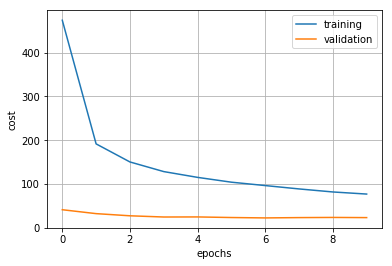

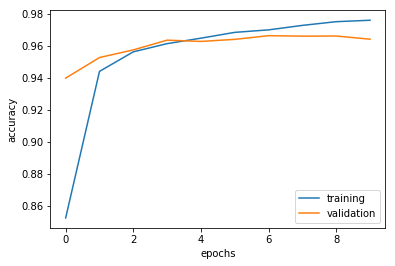

In [62]:
num_epochs = 10
batch_size = 50
learning_rate = 0.1
momentum = 0.9
linear_units = 30

# START TODO ################ 
# Train the model here!
model = Sequential(Linear(784,linear_units), Sigmoid(), Linear(linear_units,10))
params = model.parameters()
optim = SGD(params, learning_rate, momentum)
loss_fn = CrossEntropyLoss()

tc, ta, vc, va = train(model, loss_fn, optim, x_train, y_train, x_val, y_val, num_epochs, batch_size)
# END TODO ##################

# PLOT
plt.figure(1)
plt.plot(tc, label='training')
plt.plot(vc, label='validation')
plt.legend(loc='best')
plt.ylabel('cost')
plt.xlabel('epochs')
plt.grid(True)

plt.figure(2)
# Plot accuracies here
# START TODO ################ 
plt.plot(ta, label='training')
plt.plot(va, label='validation')
plt.legend(loc='best')
plt.ylabel('accuracy')
plt.xlabel('epochs')
# END TODO ##################

plt.show()

Now run again with the increased learning rate. Which accuracy can you achieve now? How did the accuracies change while training, compared to the lower learning rate?

**Note:** Make sure, to reinitialize your model's parameters. Don't continue on the already trained parameters.

**-->** With a high learning rate, the SGD does not converge and the accuracy reduces to about $\frac{1}{10}^{th}$ of their previous values.

init / self.W.shape (30, 784)
init / self.b.shape (30, 1)
init / self.W.shape (10, 30)
init / self.b.shape (10, 1)
Epoch 1 / 10:
  Training Accuracy: 0.0981
  Training Cost: 2442.8181
  Eval Accuracy: 0.1064
Epoch 2 / 10:
  Training Accuracy: 0.1002
  Training Cost: 2451.5396
  Eval Accuracy: 0.1064
Epoch 3 / 10:
  Training Accuracy: 0.1030
  Training Cost: 2459.3270
  Eval Accuracy: 0.0991
Epoch 4 / 10:
  Training Accuracy: 0.1029
  Training Cost: 2462.3062
  Eval Accuracy: 0.0991
Epoch 5 / 10:
  Training Accuracy: 0.1010
  Training Cost: 2460.4038
  Eval Accuracy: 0.1009
Epoch 6 / 10:
  Training Accuracy: 0.1020
  Training Cost: 2443.7069
  Eval Accuracy: 0.1064
Epoch 7 / 10:
  Training Accuracy: 0.1015
  Training Cost: 2453.8802
  Eval Accuracy: 0.1030
Epoch 8 / 10:
  Training Accuracy: 0.1015
  Training Cost: 2452.6329
  Eval Accuracy: 0.1064
Epoch 9 / 10:
  Training Accuracy: 0.1020
  Training Cost: 2460.7245
  Eval Accuracy: 0.1030
Epoch 10 / 10:
  Training Accuracy: 0.0993
  Tra

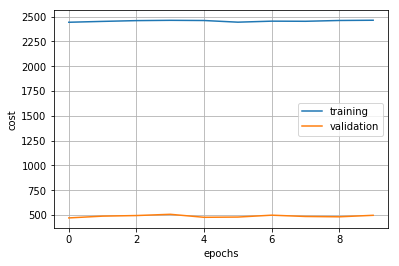

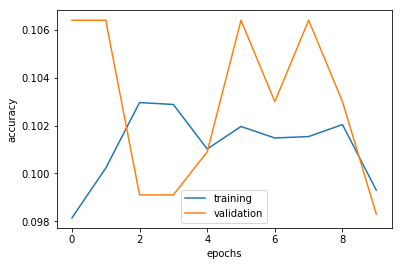

In [63]:
higher_learning_rate = 3

# START TODO ################ 
model = Sequential(Linear(784,linear_units), Sigmoid(), Linear(linear_units,10))
params = model.parameters()
optim = SGD(params, higher_learning_rate, momentum)
loss_fn = CrossEntropyLoss()

tc, ta, vc, va = train(model, loss_fn, optim, x_train, y_train, x_val, y_val, num_epochs, batch_size)
# END TODO ##################

# PLOT
plt.figure(1)
plt.plot(tc, label='training')
plt.plot(vc, label='validation')
plt.legend(loc='best')
plt.ylabel('cost')
plt.xlabel('epochs')
plt.grid(True)

plt.figure(2)
# Plot accuracies here
# START TODO ################ 
plt.plot(ta, label='training')
plt.plot(va, label='validation')
plt.legend(loc='best')
plt.ylabel('accuracy')
plt.xlabel('epochs')
# END TODO ##################

plt.show()

Train only a subset of 1000 training samples, but for 300 epochs. 
Plot the costs & accuracies for both training and validation.

How do the accuracies change compared to the previous runs?
How is this plot related to the term 'overfitting'?

**-->** Here the training accuracy becomes 100% withing 50 iterations, but the validation accuracy never touches 90%. With this being the case, the model has learned the training data but cannot generalize to the test data well.

In [64]:
num_train_samples = 1000
num_epochs = 300

# START TODO ################ 
model = Sequential(Linear(784,linear_units), Sigmoid(), Linear(linear_units,10))
params = model.parameters()
optim = SGD(params, learning_rate, momentum)
loss_fn = CrossEntropyLoss()

x_mini = x_train[:num_train_samples]
y_mini = y_train[:num_train_samples]

tc, ta, vc, va = train(model, loss_fn, optim, x_mini, y_mini, x_val, y_val, num_epochs, batch_size)
# END TODO ##################

init / self.W.shape (30, 784)
init / self.b.shape (30, 1)
init / self.W.shape (10, 30)
init / self.b.shape (10, 1)
Epoch 1 / 300:
  Training Accuracy: 0.1010
  Training Cost: 46.4506
  Eval Accuracy: 0.0991
Epoch 2 / 300:
  Training Accuracy: 0.1330
  Training Cost: 45.5110
  Eval Accuracy: 0.2004
Epoch 3 / 300:
  Training Accuracy: 0.3300
  Training Cost: 40.0943
  Eval Accuracy: 0.4310
Epoch 4 / 300:
  Training Accuracy: 0.6000
  Training Cost: 27.7872
  Eval Accuracy: 0.6189
Epoch 5 / 300:
  Training Accuracy: 0.7570
  Training Cost: 18.3293
  Eval Accuracy: 0.8000
Epoch 6 / 300:
  Training Accuracy: 0.8420
  Training Cost: 13.1972
  Eval Accuracy: 0.8334
Epoch 7 / 300:
  Training Accuracy: 0.8750
  Training Cost: 10.1495
  Eval Accuracy: 0.8417
Epoch 8 / 300:
  Training Accuracy: 0.8940
  Training Cost: 8.2907
  Eval Accuracy: 0.8592
Epoch 9 / 300:
  Training Accuracy: 0.9050
  Training Cost: 7.1046
  Eval Accuracy: 0.8677
Epoch 10 / 300:
  Training Accuracy: 0.9230
  Training Cost

  Training Accuracy: 1.0000
  Training Cost: 0.1595
  Eval Accuracy: 0.8753
Epoch 90 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1562
  Eval Accuracy: 0.8755
Epoch 91 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1544
  Eval Accuracy: 0.8748
Epoch 92 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1517
  Eval Accuracy: 0.8756
Epoch 93 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1488
  Eval Accuracy: 0.8757
Epoch 94 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1468
  Eval Accuracy: 0.8754
Epoch 95 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1445
  Eval Accuracy: 0.8747
Epoch 96 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1424
  Eval Accuracy: 0.8756
Epoch 97 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1402
  Eval Accuracy: 0.8757
Epoch 98 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1384
  Eval Accuracy: 0.8753
Epoch 99 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1364
  Eval Accuracy: 0.8754
Epoc

  Training Accuracy: 1.0000
  Training Cost: 0.0623
  Eval Accuracy: 0.8758
Epoch 179 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0618
  Eval Accuracy: 0.8758
Epoch 180 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0614
  Eval Accuracy: 0.8759
Epoch 181 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0610
  Eval Accuracy: 0.8758
Epoch 182 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0606
  Eval Accuracy: 0.8761
Epoch 183 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0602
  Eval Accuracy: 0.8759
Epoch 184 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0597
  Eval Accuracy: 0.8755
Epoch 185 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0593
  Eval Accuracy: 0.8760
Epoch 186 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0590
  Eval Accuracy: 0.8761
Epoch 187 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0585
  Eval Accuracy: 0.8761
Epoch 188 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0582
  Eval Accuracy: 0

  Training Accuracy: 1.0000
  Training Cost: 0.0378
  Eval Accuracy: 0.8752
Epoch 268 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0376
  Eval Accuracy: 0.8751
Epoch 269 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0375
  Eval Accuracy: 0.8752
Epoch 270 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0373
  Eval Accuracy: 0.8752
Epoch 271 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0371
  Eval Accuracy: 0.8750
Epoch 272 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0370
  Eval Accuracy: 0.8752
Epoch 273 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0368
  Eval Accuracy: 0.8749
Epoch 274 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0366
  Eval Accuracy: 0.8751
Epoch 275 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0365
  Eval Accuracy: 0.8750
Epoch 276 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0363
  Eval Accuracy: 0.8750
Epoch 277 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0361
  Eval Accuracy: 0

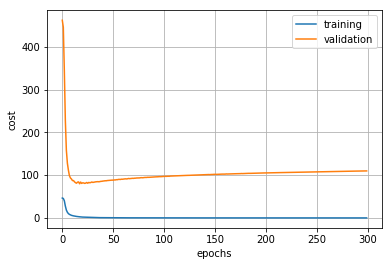

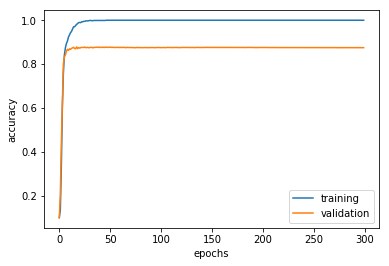

In [65]:
plt.figure(1)
plt.plot(tc, label='training')
plt.plot(vc, label='validation')
plt.legend(loc='best')
plt.ylabel('cost')
plt.xlabel('epochs')
plt.grid(True)

plt.figure(2)
# Plot accuracies here
# START TODO ################ 
plt.plot(ta, label='training')
plt.plot(va, label='validation')
plt.legend(loc='best')
plt.ylabel('accuracy')
plt.xlabel('epochs')
# END TODO ##################

plt.show()

** Your feedback on exercise 2.3: ** 

**-->** 2.3 serves as a reminder of how overfitting can happen in a NN. Useful, and this does not take a lot of time to implement.